In [1]:
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch import Tensor, nn, optim
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm.auto import tqdm

from utils import *

In [2]:
random_state = 42

df = pd.read_csv("images.csv")
df_train, df_test = train_test_split(
    df, test_size=2 / 10, stratify=df["score"], random_state=random_state
)
df_train, df_val = train_test_split(
    df_train, test_size=1 / 8, stratify=df_train["score"], random_state=random_state
)

ds_train = MRICrossSectionDataset(df_train)
ds_val = MRICrossSectionDataset(df_val)
ds_test = MRICrossSectionDataset(df_test)

In [103]:
class BasicBlock(nn.Module):
    def __conv_subblock(self, in_channels: int, out_channels: int):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=(3, 1),
                stride=1,
                padding="same",
                bias=False,
            ),
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=(1, 3),
                stride=1,
                padding="same",
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
        )

    def __init__(self, channels: int):
        super().__init__()

        self.subblock1 = self.__conv_subblock(channels, channels)
        self.rl1 = nn.ReLU()
        self.subblock2 = self.__conv_subblock(channels, channels)
        self.rl2 = nn.ReLU()

    def forward(self, x: Tensor):
        identity = x

        out = self.subblock1(x)
        out = self.rl1(out)
        out = self.subblock2(out)

        out += identity
        out = self.rl2(out)

        return out


class BottleNeck(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                in_channels,
                kernel_size=(1, 1),
                stride=1,
                padding="same",
                bias=False,
            ),
            nn.BatchNorm2d(in_channels),
        )
        self.rl1 = nn.ReLU()
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                in_channels,
                kernel_size=(3, 1),
                stride=1,
                padding="same",
                bias=False,
            ),
            nn.Conv2d(
                in_channels,
                in_channels,
                kernel_size=(1, 3),
                stride=1,
                padding="same",
                bias=False,
            ),
            nn.BatchNorm2d(in_channels),
        )
        self.rl2 = nn.ReLU()
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=(1, 1),
                stride=1,
                padding="same",
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
        )
        self.rl3 = nn.ReLU()

        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=(1, 1),
                    stride=1,
                    padding="same",
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.downsample = nn.Identity()

    def forward(self, x: Tensor):
        identity = self.downsample(x)

        out = self.conv1(x)
        out = self.rl1(out)
        out = self.conv2(x)
        out = self.rl2(out)
        out = self.conv3(x)

        out += identity
        out = self.rl3(out)

        return out


class ResidualHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.init_block = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=(7, 7), stride=2),
            nn.BatchNorm2d(4),
            nn.ReLU(),
        )

        self.res = nn.Sequential(
            BasicBlock(4),
            BasicBlock(4),
            BasicBlock(4),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2),
            BottleNeck(4, 8),
            BasicBlock(8),
            BasicBlock(8),
            BasicBlock(8),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2),
            BottleNeck(8, 16),
            BasicBlock(16),
            BasicBlock(16),
            BasicBlock(16),
        )

        self.global_pooling = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x: Tensor):
        out = self.init_block(x)
        out = self.res(out)
        out = self.global_pooling(out)

        return out


class Residual(nn.Module):
    def __init__(self):
        super().__init__()

        self.headd = ResidualHead()
        self.headw = ResidualHead()
        self.headh = ResidualHead()

        self.readout_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(48, 32, bias=True),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(32, 2, bias=True),
            nn.Softmax(dim=1),
        )

    def forward(self, xd: Tensor, xh: Tensor, xw: Tensor):
        outd = self.headd(xd)
        outh = self.headw(xh)
        outw = self.headh(xw)

        out = torch.cat((outd, outh, outw), 1)

        out = self.readout_block(out)

        return out

In [156]:
learning_rate = 0.0005
epochs = 400
batch_size = 128
patience = 10
delta = 0.01

In [157]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Residual().apply(init_weights).to(device)
summary(model, input_size=[(batch_size, 1, 256, 256), (batch_size, 1, 192, 256), (batch_size, 1, 192, 256)])

Layer (type:depth-idx)                        Output Shape              Param #
Residual                                      [128, 2]                  --
├─ResidualHead: 1-1                           [128, 16, 1, 1]           --
│    └─Sequential: 2-1                        [128, 4, 125, 125]        --
│    │    └─Conv2d: 3-1                       [128, 4, 125, 125]        200
│    │    └─BatchNorm2d: 3-2                  [128, 4, 125, 125]        8
│    │    └─ReLU: 3-3                         [128, 4, 125, 125]        --
│    └─Sequential: 2-2                        [128, 16, 30, 30]         --
│    │    └─BasicBlock: 3-4                   [128, 4, 125, 125]        208
│    │    └─BasicBlock: 3-5                   [128, 4, 125, 125]        208
│    │    └─BasicBlock: 3-6                   [128, 4, 125, 125]        208
│    │    └─MaxPool2d: 3-7                    [128, 4, 62, 62]          --
│    │    └─BottleNeck: 3-8                   [128, 8, 62, 62]          224
│    │    └─Basi

In [158]:
loader_train = DataLoader(ds_train, batch_size=batch_size)
loader_val = DataLoader(ds_val, batch_size=batch_size)
loader_test = DataLoader(ds_test, batch_size=batch_size)

In [159]:
loss_fn = nn.CrossEntropyLoss().to(device)
opt = optim.Adam(model.parameters(), lr=learning_rate)
es = EarlyStopping(patience=patience, delta=delta)

In [160]:
for epoch in tqdm(range(epochs)):
    model.train()
    for Xd, Xh, Xw, y in loader_train:
        Xd = Xd.to(device)
        Xh = Xh.to(device)
        Xw = Xw.to(device)
        y = y.to(device)

        opt.zero_grad()
        pred = model(Xd, Xh, Xw)
        cost = loss_fn(pred, y)
        cost.backward()
        opt.step()

    model.eval()
    with torch.no_grad():
        val_loss = sum(
            loss_fn(model(Xd.to(device), Xh.to(device), Xw.to(device)), y.to(device))
            for Xd, Xh, Xw, y in loader_val
        )

    es.evaluate(model, val_loss)

    print(
        f"Epoch {epoch}: val_loss={val_loss / len(loader_val)}, early_stopping_count={es.counter}"
    )

    if es.should_stop():
        model = es.load_best(model)
        break

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 0: val_loss=0.7675693035125732, early_stopping_count=0
Epoch 1: val_loss=0.7588937878608704, early_stopping_count=1
Epoch 2: val_loss=0.7473170757293701, early_stopping_count=0
Epoch 3: val_loss=0.7362868189811707, early_stopping_count=0
Epoch 4: val_loss=0.7251416444778442, early_stopping_count=0
Epoch 5: val_loss=0.7107172608375549, early_stopping_count=0
Epoch 6: val_loss=0.692559003829956, early_stopping_count=0
Epoch 7: val_loss=0.6757128834724426, early_stopping_count=0
Epoch 8: val_loss=0.6626402139663696, early_stopping_count=0
Epoch 9: val_loss=0.6546956896781921, early_stopping_count=1
Epoch 10: val_loss=0.6603295207023621, early_stopping_count=2
Epoch 11: val_loss=0.6767452359199524, early_stopping_count=3
Epoch 12: val_loss=0.6956775784492493, early_stopping_count=4
Epoch 13: val_loss=0.7210977077484131, early_stopping_count=5
Epoch 14: val_loss=0.7359673976898193, early_stopping_count=6
Epoch 15: val_loss=0.7340989112854004, early_stopping_count=7
Epoch 16: val_loss=

In [161]:
# model.load_state_dict(torch.load('residualflat_2_240403_01.pth'))

In [162]:
y_true_raw = []
y_pred_raw = []

model.eval()
with torch.no_grad():
    for Xd, Xh, Xw, y in loader_test:
        Xd = Xd.to(device)
        Xh = Xh.to(device)
        Xw = Xw.to(device)
        y = y.to(device)

        pred = model(Xd, Xh, Xw)

        y_true_raw.append(y)
        y_pred_raw.append(pred)

y_true_raw = torch.concatenate(y_true_raw).cpu().numpy()
y_pred_raw = torch.concatenate(y_pred_raw).cpu().numpy()

In [163]:
y_true = y_true_raw.argmax(axis=1)
y_pred = y_pred_raw.argmax(axis=1)
y_true, y_pred

(array([1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1]),
 array([1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1]))

In [164]:
confusion_matrix(y_true, y_pred)

array([[45,  3],
       [ 2, 38]])

In [165]:
np.where((y_true == 1) & (y_pred == 0))

(array([41, 47]),)

In [166]:
np.where((y_true == 0) & (y_pred == 1))

(array([19, 22, 36]),)

In [116]:
Xd, Xh, Xw, y = ds_test[8]

In [117]:
import matplotlib.pyplot as plt

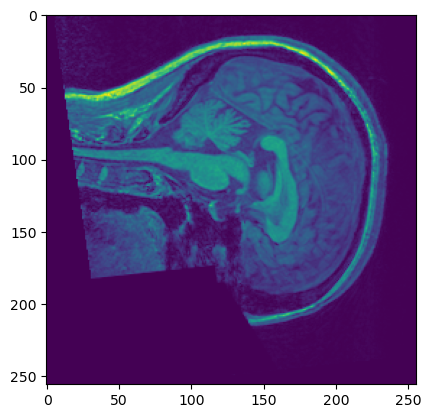

In [118]:
plt.imshow(Xd[0])

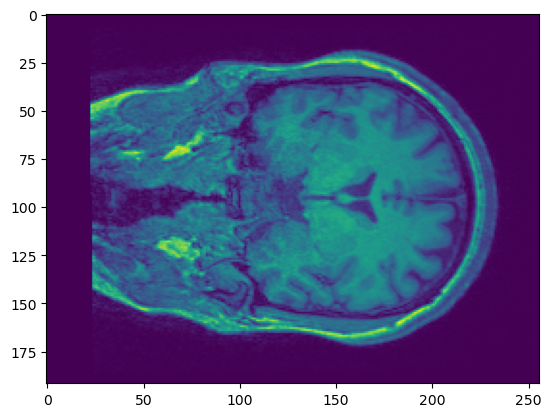

In [119]:
plt.imshow(Xh[0])

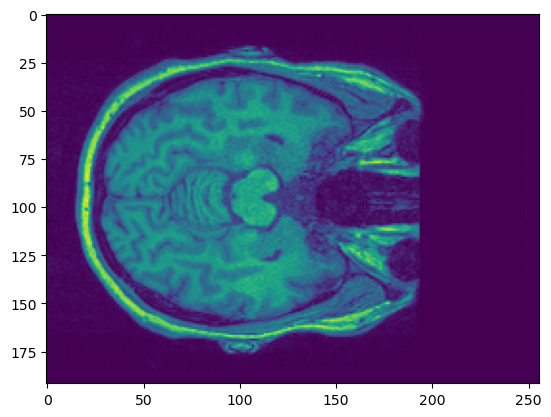

In [120]:
plt.imshow(Xw[0])